In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType

In [2]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

In [4]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("bigram_percent", FloatType(), True),
    StructField("bigram_percent_smooth", FloatType(), True)])

In [5]:
df = spark.read.option('header', False).schema(schema)\
                     .csv('/data/shared1/cleandata/ntile40_allyears')

In [6]:
df.show(10)

+-------------------+----+-----+--------------+---------------------+
|             bigram|year|count|bigram_percent|bigram_percent_smooth|
+-------------------+----+-----+--------------+---------------------+
|ages_noun past_noun|1900| 1424|   1.759116E-5|         1.7512104E-5|
|ages_noun past_noun|1901| 1421|  1.7039405E-5|         1.7287994E-5|
|ages_noun past_noun|1902| 1479|  1.7905744E-5|         1.6872733E-5|
|ages_noun past_noun|1903| 1383|  1.6615666E-5|         1.6350888E-5|
|ages_noun past_noun|1904| 1335|  1.5211687E-5|         1.5827794E-5|
|ages_noun past_noun|1905| 1309|  1.4981942E-5|         1.5184257E-5|
|ages_noun past_noun|1906| 1362|  1.4423936E-5|         1.4964964E-5|
|ages_noun past_noun|1907| 1394|  1.4688054E-5|          1.509685E-5|
|ages_noun past_noun|1908| 1532|  1.5519201E-5|         1.5185702E-5|
|ages_noun past_noun|1909| 1539|  1.5871117E-5|         1.4891665E-5|
+-------------------+----+-----+--------------+---------------------+
only showing top 10 

## Cluster ngrams

First we cluster all ngrams and hope to find a few clusters that exhibit mainstream tendencies. 

In [7]:
clusterdf = df.drop('year')

### KShape

In [8]:
import tslearn as ts
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_normalized_cc

/home2/s154326/.conda/envs/Thesis/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import collect_list

In [10]:
vecAssembler = VectorAssembler(inputCols=["bigram_percent"], outputCol="bigram_percent_array")
#vecAssembler = VectorAssembler(inputCols=["count"], outputCol="count_array")
dfvec = vecAssembler.transform(clusterdf)

In [11]:
grouped_bigrams = dfvec.groupBy('bigram').agg(collect_list('bigram_percent_array').alias('percentages'))
#grouped_bigrams = dfvec.groupBy('bigram').agg(collect_list('count_array').alias('counts'))

In [12]:
grouped_bigrams = clusterdf.groupBy('bigram').agg(collect_list('bigram_percent').alias('percentages'))

In [13]:
grouped_bigrams_sample = grouped_bigrams.limit(5000)

In [14]:
Xbigram = np.array(grouped_bigrams.select('percentages').collect())
#Xbigram = np.array(grouped_bigrams_sample.select('percentages').collect())

In [15]:
#X = np.zeros((len(Xbigram), 120, 1))
#for i in range(len(Xbigram)):
#    X[i] = Xbigram[i][0]
    
X = np.zeros((len(Xbigram), 120))
for i in range(len(Xbigram)):
    X[i] = Xbigram[i][0]

In [16]:
from sklearn.preprocessing import MinMaxScaler

Xtranspose = np.transpose(X)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(Xtranspose)
Xt = np.transpose(X_normalized)

In [ ]:
distortions = []
K = range(2,10)
for k in K:
    ks = KShape(n_clusters=k, n_init=2, max_iter=100, random_state=0)
    ks.fit(Xt)
    distortions.append(ks.inertia_)

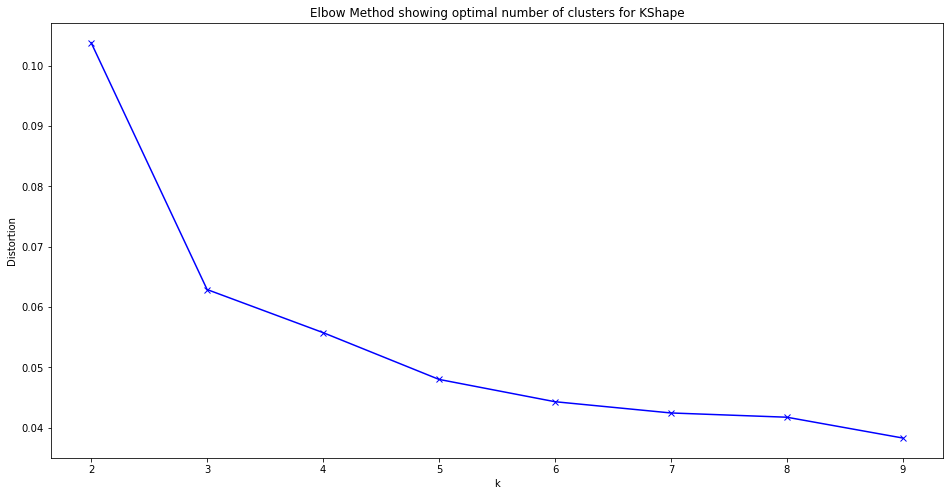

In [19]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing optimal number of clusters for KShape')
plt.show()

In [20]:
silhouette_arr_ks = []
K = range(2,8)
for k in K:
    ks = KShape(n_clusters=k, n_init=3, max_iter=100, random_state=0)
    assignKS = ks.fit_predict(Xt)
    norms = []
    for x in X:
        result = np.linalg.norm(x)
        norms.append(result)
    norms = np.array(norms)
    dists = 1. - cdist_normalized_cc(X, X, norms1=norms, norms2=norms, self_similarity=False)
    np.fill_diagonal(dists, 0)
    silhouette_arr_ks.append(silhouette_score(dists, assignKS, metric="precomputed"))

In [21]:
silhouette_arr_ks

[0.11227473801226168,
 0.10215642782386047,
 0.10423042451193232,
 0.02301831893294342,
 0.0187454571119573,
 -0.010338066119172101]

In [19]:
ks = KShape(n_clusters=3, n_init=3, max_iter=100, random_state=0)

In [20]:
# cluster transformed data
assignKS = ks.fit_predict(X)

In [55]:
norms = []
for x in X:
    result = np.linalg.norm(x)
    norms.append(result)
norms = np.array(norms)

In [56]:
dists = 1. - cdist_normalized_cc(X, X, norms1=norms, norms2=norms, self_similarity=False)
np.fill_diagonal(dists, 0)
silhouette_score(dists, assignKS, metric="precomputed")

0.07936719771215303

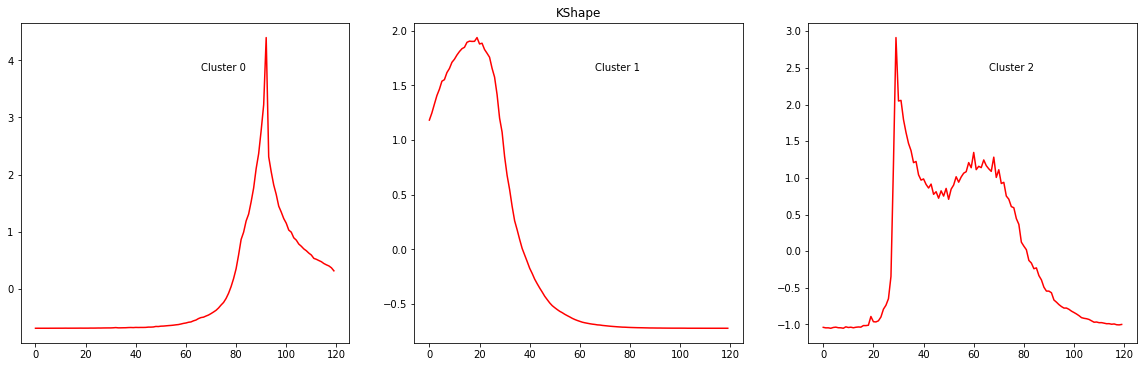

In [21]:
# plot centroids
plt.figure(figsize=(20,20))
for yi in range(3):
    plt.subplot(3, 3, yi+1)
    #for xx in Xt[assignKS == yi]:
    #    plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("KShape")

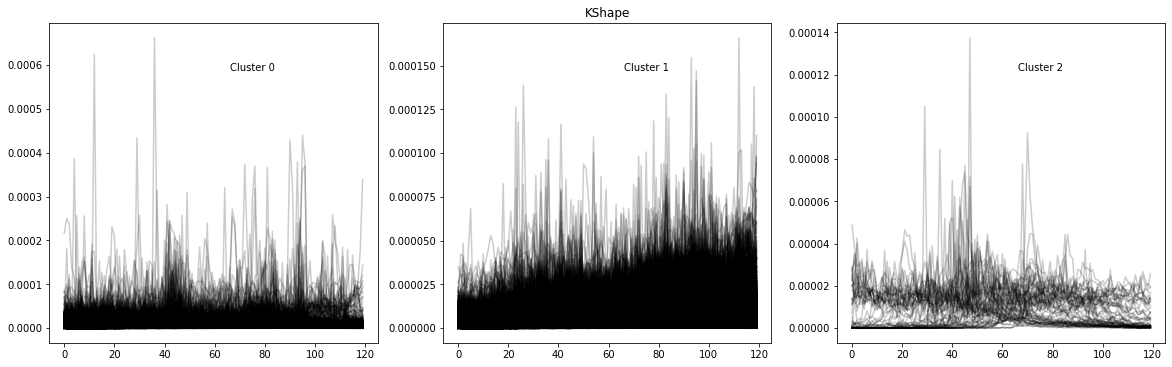

In [22]:
# plot data
plt.figure(figsize=(20,20))
for yi in range(3):
    plt.subplot(3, 3, yi+1)
    for xx in X[assignKS == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    #plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("KShape")

### Link cluster assignments to ngrams

In [23]:
#grouped_bigrams_sample.createOrReplaceTempView('grouped_bigrams_sample')
#grouped_bigrams_sample = spark.sql('select row_number() over (order by "bigram") as id, * from grouped_bigrams_sample')

In [23]:
grouped_bigrams.createOrReplaceTempView('grouped_bigrams')
grouped_bigrams = spark.sql('select row_number() over (order by "bigram") as id, * from grouped_bigrams')

In [24]:
def link_assignments(assign):
    assign_pd = pd.DataFrame(assign, columns=["assign"])
    assign_df = spark.createDataFrame(assign_pd, ["assign"])
    
    assign_df.createOrReplaceTempView('assign_df')
    assign_df = spark.sql('select row_number() over (order by "assign") as id, * from assign_df')
    
    assignments = grouped_bigrams.join(assign_df, ['id'], how='inner')
    #assignments = grouped_bigrams_sample.join(assign_df, ['id'], how='inner')
    
    return assignments

In [25]:
assignmentsKS = link_assignments(assignKS)

In [26]:
# max year
assignmentsKS = assignmentsKS.withColumn('maxyear',F.expr('array_position(percentages,array_max(percentages))')+1899)

In [27]:
assignmentsKS = assignmentsKS.withColumn('label', when((col('assign')== 0) | (col('assign')== 4) | (col('assign')== 6), 1).otherwise(0))
assignmentsKS = assignmentsKS.drop('id')

In [28]:
assignmentsKS = df.join(assignmentsKS.select('bigram','label','maxyear', 'assign'), ['bigram'], how='inner')

In [29]:
clusterKS4 = assignmentsKS.where(col('assign') == 4)
clusterKS3 = assignmentsKS.where(col('assign') == 3)
clusterKS2 = assignmentsKS.where(col('assign') == 2)
clusterKS1 = assignmentsKS.where(col('assign') == 1)
clusterKS0 = assignmentsKS.where(col('assign') == 0)

In [124]:
# save data
assignmentsKS = assignmentsKS.drop('assign')
assignmentsKS.write.csv('Data/ClusteredData.csv')

AnalysisException: path file:/home2/s153445/Thesis/Data/ClusteredData.csv already exists.;

### Plot ngrams in clusters

In [30]:
clusterKS0 = clusterKS0.limit(50*120)
clusterKS1 = clusterKS1.limit(50*120)
clusterKS2 = clusterKS2.limit(50*120)
clusterKS3 = clusterKS3.limit(50*120)
clusterKS4 = clusterKS4.limit(50*120)

In [31]:
clusterKSpd0 = clusterKS0.toPandas()
clusterKSpd1 = clusterKS1.toPandas()
clusterKSpd2 = clusterKS2.toPandas()
#clusterKSpd3 = clusterKS3.toPandas()
#clusterKSpd4 = clusterKS4.toPandas()

In [32]:
def plot_mainstream(model):
    mainstream_bigrams = list(model['bigram'].unique())
    fig = plt.figure()
    plt.figure(figsize=(15,70))

    for i in range(0, len(mainstream_bigrams)): 
        ax = plt.subplot(25, 2, i+1)
        plt.subplots_adjust(hspace = 0.3)
        tmp = model[model['bigram'] == mainstream_bigrams[i]]
        ax.plot(tmp.year, tmp['bigram_percent'])
        plt.title(mainstream_bigrams[i])
        plt.xlabel('')
        plt.ylabel('')

    plt.show()

<Figure size 432x288 with 0 Axes>

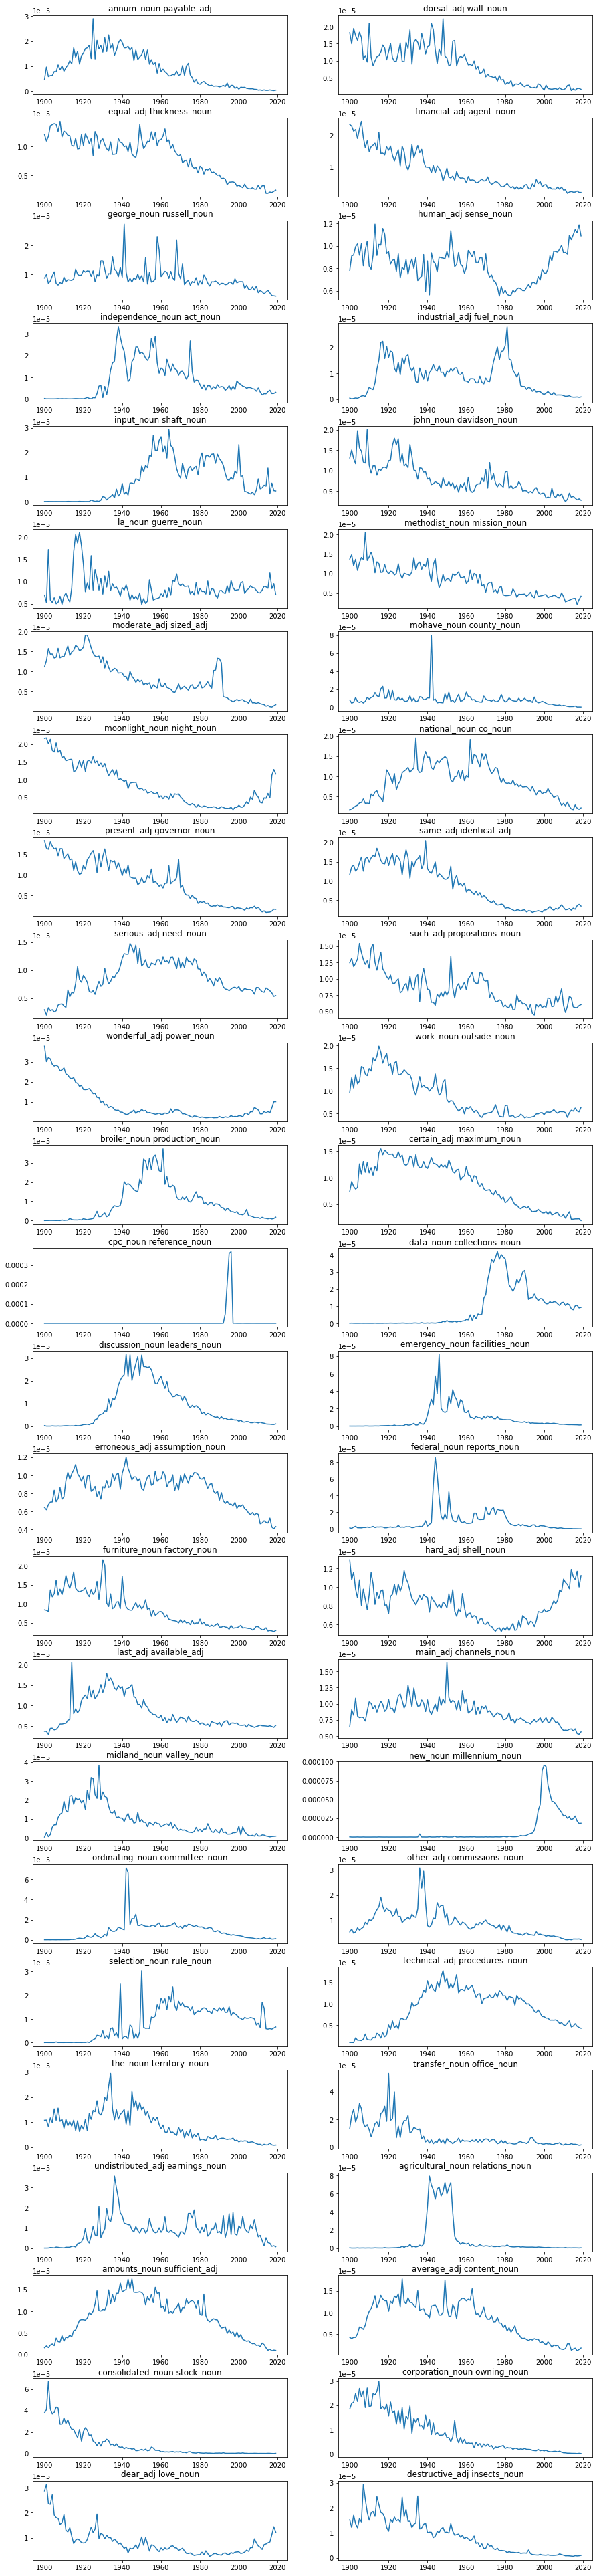

In [33]:
plot_mainstream(clusterKSpd0)

<Figure size 432x288 with 0 Axes>

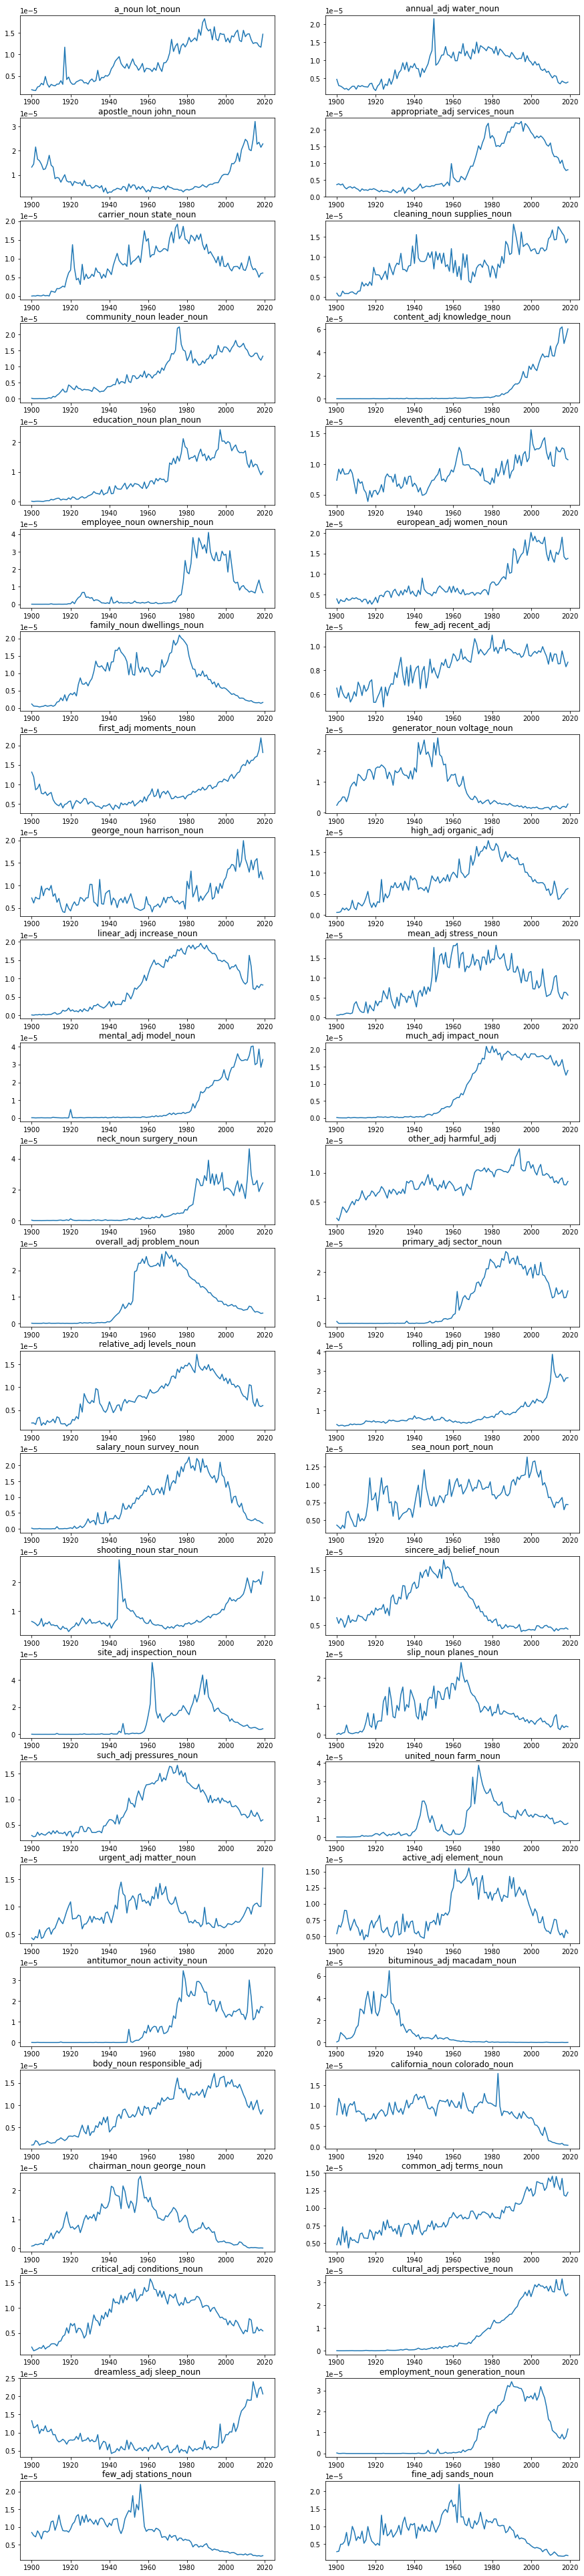

In [34]:
plot_mainstream(clusterKSpd1)

<Figure size 432x288 with 0 Axes>

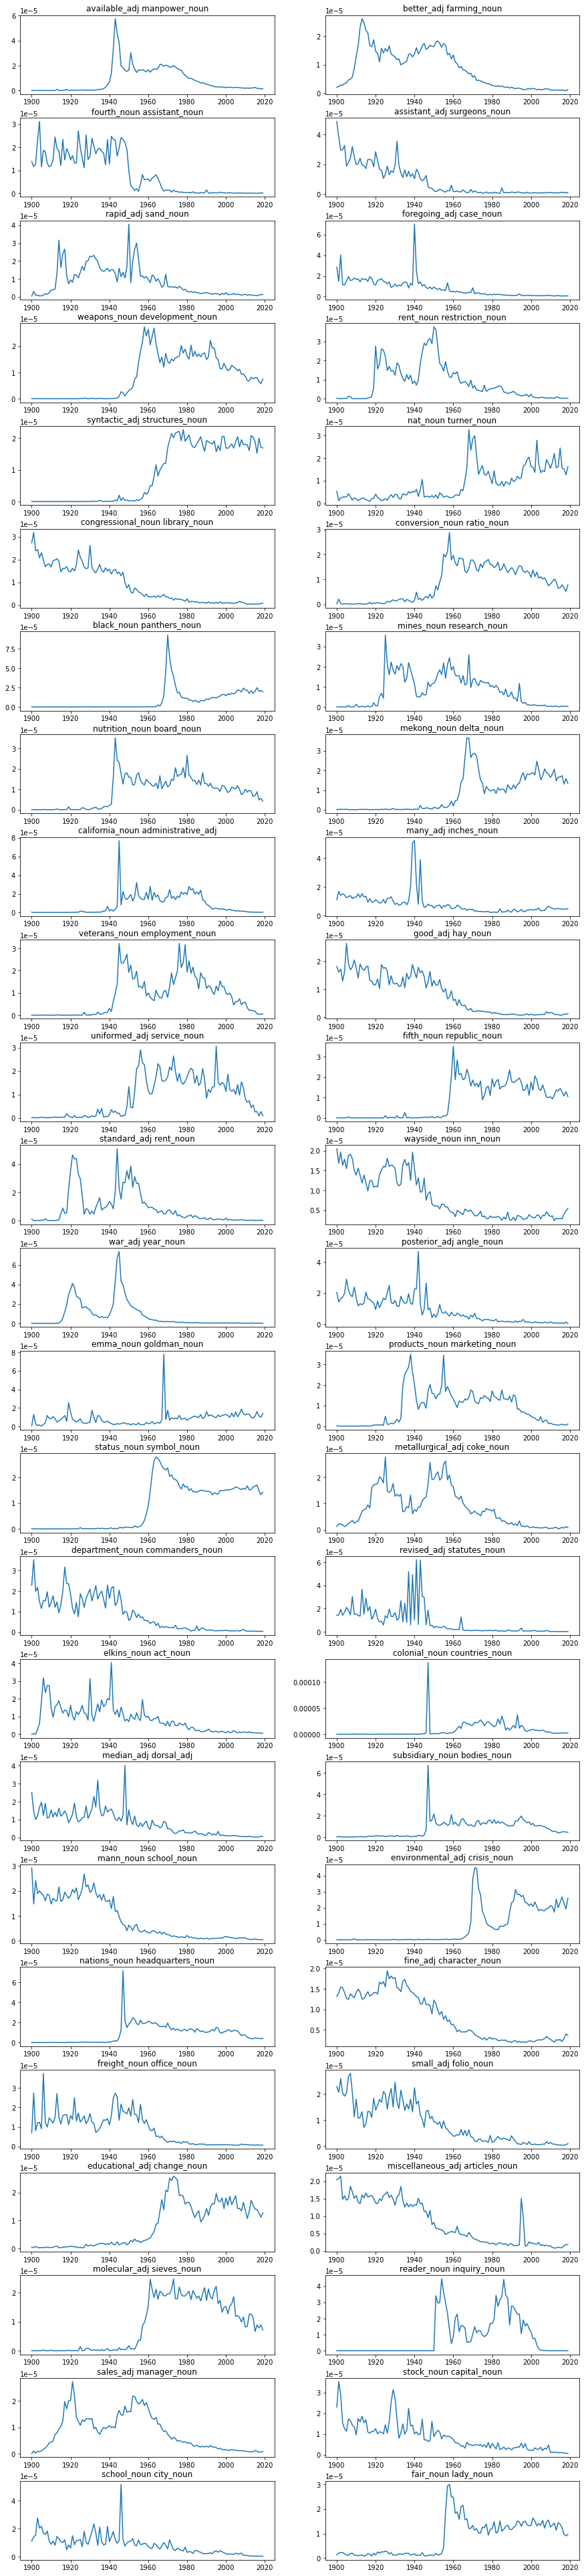

In [35]:
plot_mainstream(clusterKSpd2)

In [72]:
plot_mainstream(clusterKSpd3)

<Figure size 432x288 with 0 Axes>

<Figure size 1080x5040 with 0 Axes>